##### Start

In [2]:
# import phi.torch
from PIL import Image
import torch
from phi.torch.flow import *

class NavigationNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Linear(6, 16),  # Input: [bot_x, bot_y, goal_x, goal_y, world_theta, relative_theta]
            torch.nn.ReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            # torch.nn.Linear(64, 128),
            # torch.nn.ReLU(),
            # torch.nn.Linear(128, 64),
            # torch.nn.ReLU(),
            # torch.nn.Linear(64, 32),
            # torch.nn.ReLU(),
            # torch.nn.Linear(32, 16),
            # torch.nn.ReLU(),
        )
        self.linear_head = torch.nn.Sequential(
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()  # L will be in [0,1]
        )
        self.angular_head = torch.nn.Sequential(
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Tanh()  # delta_theta will be in [-1,1]
        )
        
    def forward(self, current_state):
        features = self.features(current_state)
        L = self.linear_head(features).squeeze(-1)  # shape: (batch,)
        delta_theta = self.angular_head(features).squeeze(-1)  # shape: (batch,)
        # Stack outputs into one tensor of shape (batch, 2)
        return torch.stack([L, delta_theta], dim=-1)

In [3]:
def simulate_trajectory(net, initial_pos, goal_pos, max_steps=20):

    current_pos = initial_pos
    theta = math.zeros(initial_pos.shape.non_channel)
    total_loss = 0
    path_length = 0  # Track total distance traveled
    prev_controls = None  # For control smoothness
    net = net.to('cuda')
    # --- New: Store trajectory for final position loss ---
    trajectory = [current_pos]

    eps = 1e-6

    
    for step in range(max_steps):
        delta_pos = goal_pos - current_pos

        # Temporal discount factor ---
        temporal_weight = 0.85 ** (step*-1)
        
        # Calculate relative angle using existing vector components
        relative_theta = math.arctan(delta_pos.vector['y'], divide_by=delta_pos.vector['x']+eps) - theta

        relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi 
        
        # Network input
        net_input = math.stack([
            current_pos.vector['x']/8, 
            current_pos.vector['y']/6,
            goal_pos.vector['x']/8,
            goal_pos.vector['y']/6,
            theta/math.PI,
            relative_theta/math.PI
        ], channel('input_features'))
        
        # Network prediction
        controls = math.native_call(net, net_input)
        L = controls.vector[0]
        delta_theta = controls.vector[1]*math.PI + np.random.uniform(low=0, high=0.5, size=1)[0]*math.PI
        delta_theta = (delta_theta + math.PI) % (2*math.PI) - math.PI

        if prev_controls is not None:
            control_change = math.vec_squared(controls - prev_controls)
            total_loss += 0.25 * math.mean(control_change)
        prev_controls = controls

        # Update orientation with physical constraints
        # theta += math.clip(delta_theta, -math.PI/9, math.PI/9)
        theta += delta_theta

        theta = (theta + np.pi) % (2 * np.pi) - np.pi 
        
        # Calculate movement using existing vector dimension
        delta_x = L * math.cos(theta)
        delta_y = L * math.sin(theta)

        movement = math.stack([delta_x, delta_y], dim=channel(vector='x,y'))

        # --- New: Track path length ---
        path_length += math.vec_length(movement)
        
        # Update position
        new_pos = current_pos + movement
        trajectory.append(new_pos)

        # --- Improved: Discounted position loss ---
        position_loss = temporal_weight * math.vec_length(delta_pos)
        control_loss = 0.1 * (math.abs(delta_theta))
        
        total_loss += math.mean(position_loss  + control_loss) #
        
        current_pos = math.where(math.vec_length(delta_pos) > 0.1, new_pos, current_pos)
    
    final_pos_loss = 10.0 * math.vec_length(trajectory[-1] - goal_pos)
    
    # --- New: Path efficiency penalty ---
    straight_line_dist = math.vec_length(goal_pos - initial_pos)
    efficiency_loss = 0.9 * (path_length / (straight_line_dist + eps))  # Prevent div/0
    
    return total_loss + math.mean(final_pos_loss + efficiency_loss)


In [4]:
def generate_batch(batch_size, min_distance=0.1, max_distance=20):
    batch_dim = batch(samples=batch_size)
    vec_dim = channel(vector='x,y')
    
    # Generate initial positions
    initial_x = math.random_uniform(batch_dim, low=-8, high=8)
    initial_y = math.random_uniform(batch_dim, low=-6,  high=6)
    initial_pos = math.stack([initial_x, initial_y], vec_dim)
    
    # Generate random displacement direction (angles)
    angle = math.random_uniform(batch_dim, low=-math.pi, high=math.pi)
    
    # Generate displacement magnitudes between [min_distance, 2*min_distance]
    distance = math.random_uniform(batch_dim, low=min_distance, high=max_distance)
    
    # Compute displacement components
    dx = distance * math.cos(angle)
    dy = distance * math.sin(angle)
    
    # Apply displacement to initial positions
    goal_x = (initial_x + dx)
    goal_y = (initial_y + dy)
    
    # Clamp goals to stay within bounds
    goal_x = math.clip(goal_x, -7.9, 7.9)
    goal_y = math.clip(goal_y, -5.9, 5.9)
    
    goal_pos = math.stack([goal_x, goal_y], vec_dim)
    
    return initial_pos, goal_pos

In [5]:
def physics_loss(net, initial_pos, goal_pos):
    return simulate_trajectory(net, initial_pos, goal_pos)

In [6]:
import numpy as np
import cv2

def get_lidar_points(binary_img, current_pos, world_limits, num_rays=360, max_range=4.0):
    """
    Get LiDAR first contact points in world coordinates using vectorized operations
    Args:
        binary_img: Binary image where 0 is obstacle, 1 is free space
        current_pos: (x,y) position of the sensor in world coordinates
        world_limits: Array of [[min_x, max_x], [min_y, max_y]] world boundaries
        num_rays: Number of rays to cast (default 360 for 1-degree resolution)
        max_range: Maximum range of the sensor in world units
    Returns:
        points: Array of shape (360,2) with (x,y) coordinates relative to sensor position,
               zeros for rays that don't hit anything
    """
    height, width = binary_img.shape
    # Calculate transformation factors from world to image
    world_width = world_limits[0][1] - world_limits[0][0]
    world_height = world_limits[1][1] - world_limits[1][0]
    scale_x = width / world_width
    scale_y = height / world_height
    # Convert world position to image coordinates
    img_x = int((current_pos[0] - world_limits[0][0]) * scale_x)
    img_y = height - int((current_pos[1] - world_limits[1][0]) * scale_y)
    # Convert max_range to pixels
    max_range_px = int(max_range * min(scale_x, scale_y))
    # Generate all angles at once
    angles = np.linspace(0, 2*np.pi, num_rays, endpoint=False)
    # Generate direction vectors for all angles
    directions = np.stack([np.cos(angles), -np.sin(angles)], axis=0)  # Shape: (2, num_rays)
    # Generate all ray lengths at once
    ray_lengths = np.arange(1, max_range_px)  # Shape: (max_range_px-1,)
    # Calculate all possible points for all rays using broadcasting
    ray_points = (ray_lengths[:, np.newaxis, np.newaxis] * directions[np.newaxis, :, :])
    ray_points = np.transpose(ray_points, (0, 2, 1))  # Reshape to (max_range_px-1, num_rays, 2)
    # Add sensor position to all points
    ray_points_x = ray_points[..., 0] + img_x  # Shape: (max_range_px-1, num_rays)
    ray_points_y = ray_points[..., 1] + img_y
    # Convert to integer coordinates
    ray_points_x = ray_points_x.astype(np.int32)
    ray_points_y = ray_points_y.astype(np.int32)
    # Create masks for valid points
    valid_x = (ray_points_x >= 0) & (ray_points_x < width)
    valid_y = (ray_points_y >= 0) & (ray_points_y < height)
    valid_points = valid_x & valid_y
    # Initialize array to store contact points (replacing the contact_points list)
    contact_points = np.zeros((num_rays, 2))
    lidar_dists = np.ones(num_rays) * np.inf
    # Find first contact points for each ray
    for ray_idx in range(num_rays):
        valid_ray_points = valid_points[:, ray_idx]
        if not np.any(valid_ray_points):
            continue
        ray_x = ray_points_x[valid_ray_points, ray_idx]
        ray_y = ray_points_y[valid_ray_points, ray_idx]
        # Check for obstacles along the ray
        ray_values = binary_img[ray_y, ray_x]
        obstacle_indices = np.where(ray_values == 0)[0]
        if len(obstacle_indices) > 0:
            # Get first contact point
            first_contact_idx = obstacle_indices[0]
            px = ray_x[first_contact_idx]
            py = ray_y[first_contact_idx]
            # Convert back to world coordinates
            world_x = (px / scale_x) + world_limits[0][0]
            world_y = world_limits[1][0] + (height - py) / scale_y
            # Calculate relative coordinates
            rel_x = world_x - current_pos[0]
            rel_y = world_y - current_pos[1]
            dists = np.sqrt(rel_x**2 + rel_y**2)
            # Check if within max range
            if dists <= max_range:
                contact_points[ray_idx] = [rel_x, rel_y]
                lidar_dists[ray_idx] = dists
    return contact_points, lidar_dists

In [12]:
import matplotlib.pyplot as plt
import torch

def plot_trajectory(net, initial_pos, goal_pos, max_steps=20):
    """Simulate and plot a single trajectory using PyTorch tensors"""
    with torch.no_grad():
        current_pos = initial_pos.clone()
        goal_pos = goal_pos.clone()
        # net = net.to('cuda')
        net = net.to('cpu')

        print(current_pos, goal_pos)
        
        theta = torch.zeros_like(current_pos[0])
        positions = []
        lidar_pts = []
        
        for stp in range(max_steps):
            delta_pos = goal_pos - current_pos
            relative_theta = torch.atan2(delta_pos[1], delta_pos[0]) - theta

            relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi

            image_path = "New_WR_World.png"
            img = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale
            binary_img = (img > 128).astype(np.uint8)  # Threshold to create a binary map
            binary_img = cv2.resize(binary_img, (0,0), fx=0.25, fy=0.25)
            pts, dists = get_lidar_points(binary_img, [4,4], [(-10, 10),(-8, 8)], num_rays=360, max_range=5.0)
            lidar_pts.append(pts+current_pos.cpu().numpy())
            
            net_input = torch.stack([
                current_pos[0]/8, current_pos[1]/6,
                goal_pos[0]/8, goal_pos[1]/6,
                theta/math.PI, relative_theta/math.PI
            ], dim=-1).unsqueeze(0)
            
            controls = net(net_input)[0]
            L = controls[0]
            delta_theta = controls[1]*math.PI + np.random.uniform(low=0, high=0.5, size=1)[0]*math.PI
            delta_theta = (delta_theta + math.PI) % (2*math.PI) - math.PI

            # print(L, delta_theta, theta, torch.clip(delta_theta, -math.PI/9, math.PI/9))

            theta = theta + delta_theta
            theta = (theta + np.pi) % (2 * np.pi) - np.pi 

            # print(L, theta, dists.shape)

            # adjust_direction(lidar_points, proposed_displacement, n)


            # print("step", stp, " ", np.rad2deg(theta), net_input)
        
            
            # theta += delta_theta
            movement = torch.stack([
                L * torch.cos(theta),
                L * torch.sin(theta)
            ])


            
            current_pos += movement
            # Append a copy of the numpy array to avoid reference issues
            positions.append(current_pos.cpu().numpy().copy())  # Fixed line
            
            if torch.norm(delta_pos) < 0.1:
                break
        
        positions = np.array(positions)
        # Rest of the plotting code remains the same
        plt.figure(figsize=(8, 6))
        plt.plot(positions[:, 0], positions[:, 1], 'b-o', markersize=4, label='Path')
        # for pt in lidar_pts:
            # plt.plot(pt[:, 0], pt[:, 1], 'r.', markersize=1)
        plt.scatter(positions[0, 0], positions[0, 1], c='green', s=200, marker='*', label='Start')
        plt.scatter(goal_pos[0].item(), goal_pos[1].item(), c='red', s=200, marker='X', label='Goal')
        plt.title("Navigation Trajectory")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid(True)
        plt.axis('equal')
        plt.legend()
        plt.show()


C:\Users\rahat\AppData\Local\Temp\ipykernel_21188\3627828045.py:60: DeprecationWarning: phiml.math.length is deprecated in favor of phiml.math.norm
  path_length += math.vec_length(movement)
C:\Users\rahat\AppData\Local\Temp\ipykernel_21188\3627828045.py:67: DeprecationWarning: phiml.math.length is deprecated in favor of phiml.math.norm
  position_loss = temporal_weight * math.vec_length(delta_pos)
C:\Users\rahat\AppData\Local\Temp\ipykernel_21188\3627828045.py:72: DeprecationWarning: phiml.math.length is deprecated in favor of phiml.math.norm
  current_pos = math.where(math.vec_length(delta_pos) > 0.1, new_pos, current_pos)
C:\Users\rahat\AppData\Local\Temp\ipykernel_21188\3627828045.py:43: DeprecationWarning: phiml.math.vec_squared is deprecated in favor of phiml.math.squared_norm
  control_change = math.vec_squared(controls - prev_controls)
C:\Users\rahat\AppData\Local\Temp\ipykernel_21188\3627828045.py:74: DeprecationWarning: phiml.math.length is deprecated in favor of phiml.math.n

Epoch 0, Loss: 818.4584
tensor([ 0.1636, -5.1479], device='cuda:0') tensor([ 6.5487, -5.9000], device='cuda:0')


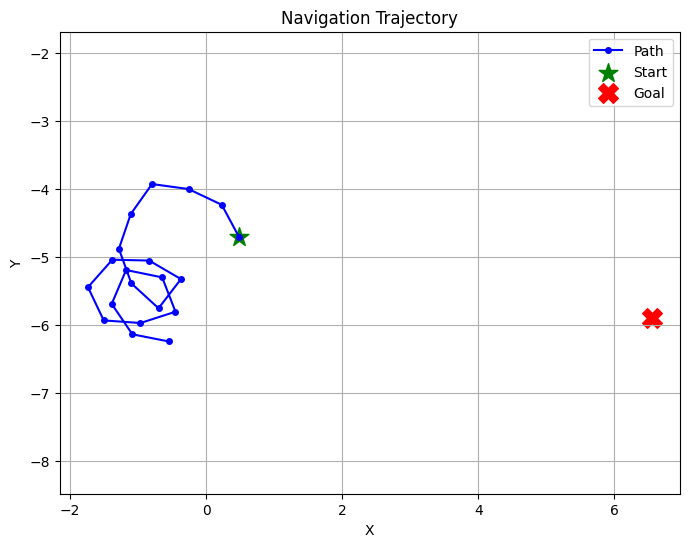

Epoch 500, Loss: 63.9286
tensor([ 0.9798, -5.9153], device='cuda:0') tensor([ 1.3798, -1.2004], device='cuda:0')


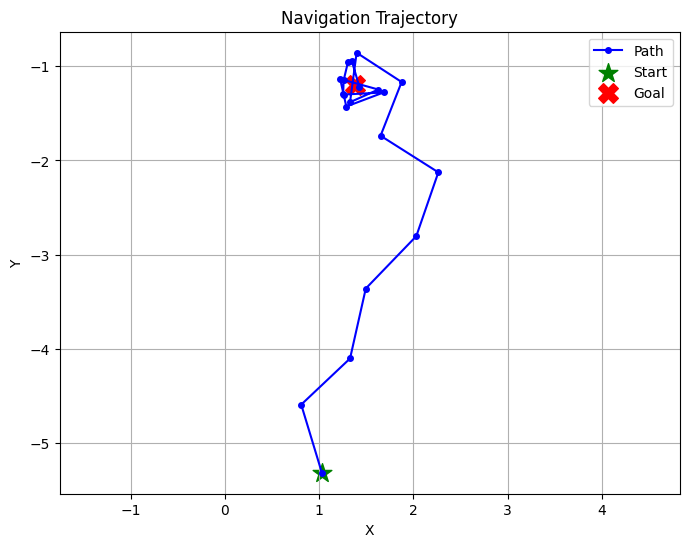

Epoch 1000, Loss: 83.0509
tensor([-3.1828,  0.4778], device='cuda:0') tensor([-7.9000,  5.9000], device='cuda:0')


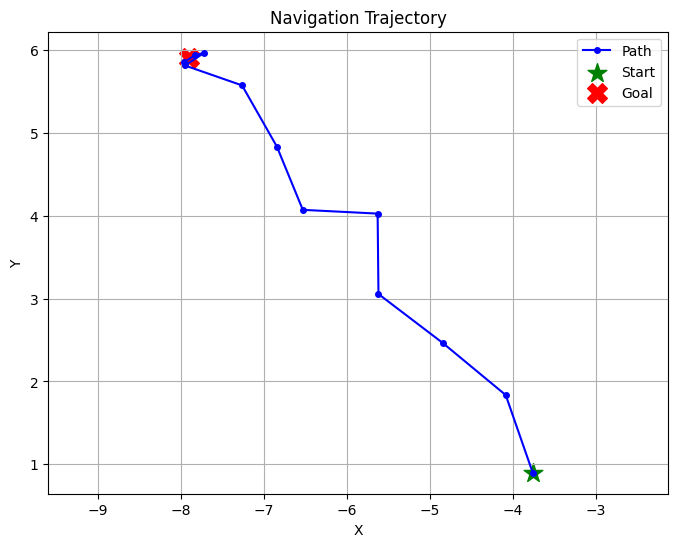

Epoch 1500, Loss: 52.9018
tensor([-2.3714, -4.8300], device='cuda:0') tensor([ 3.5263, -5.9000], device='cuda:0')


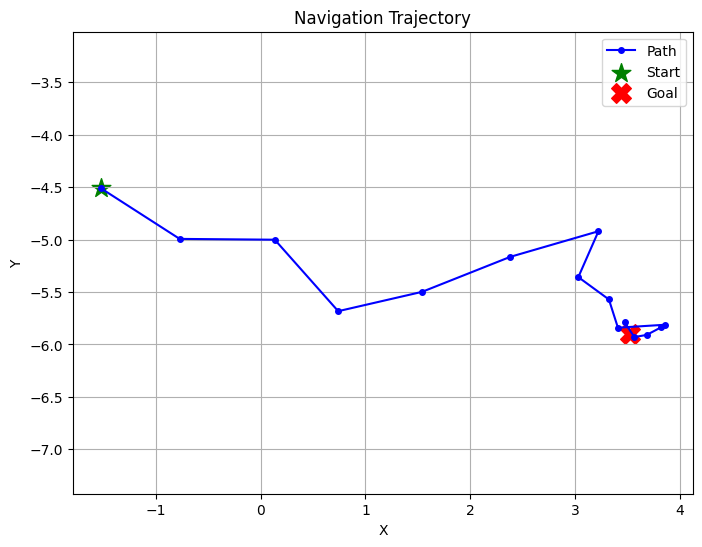

Epoch 2000, Loss: 211.6151
tensor([-6.0049,  4.5727], device='cuda:0') tensor([-1.9494, -5.9000], device='cuda:0')


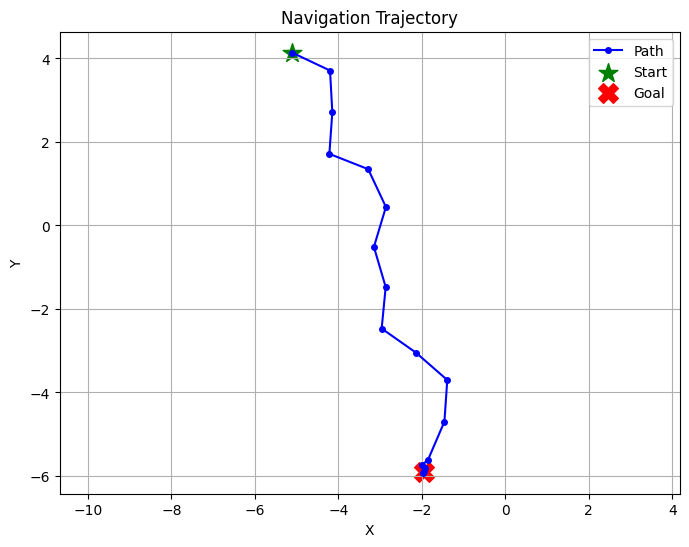

Epoch 2500, Loss: 58.1483
tensor([0.1013, 5.6717], device='cuda:0') tensor([4.9758, 1.7256], device='cuda:0')


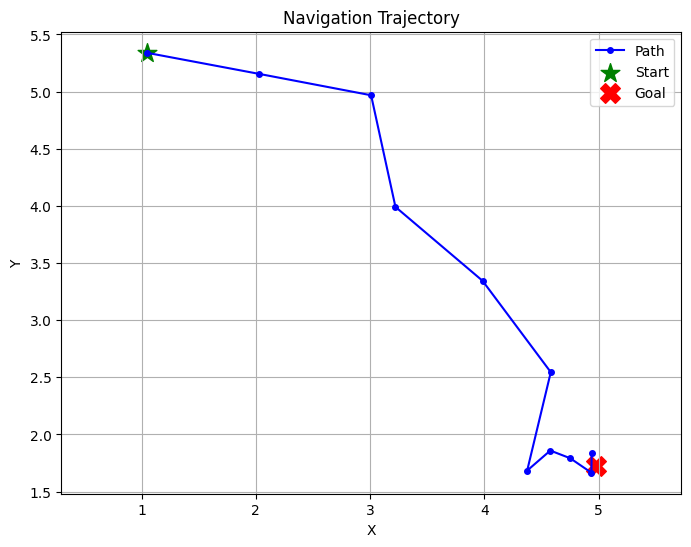

Epoch 3000, Loss: 35.9245
tensor([1.9558, 4.7797], device='cuda:0') tensor([-2.7795,  5.9000], device='cuda:0')


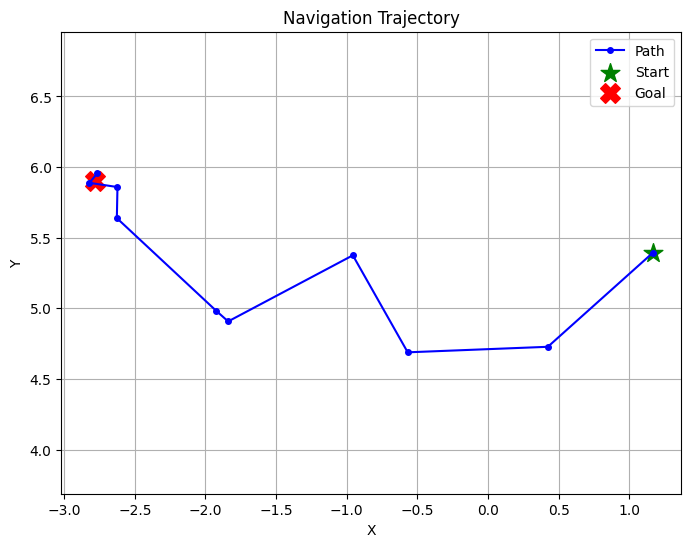

Epoch 3500, Loss: 74.2212
tensor([6.3280, 1.7712], device='cuda:0') tensor([ 7.9000, -5.9000], device='cuda:0')


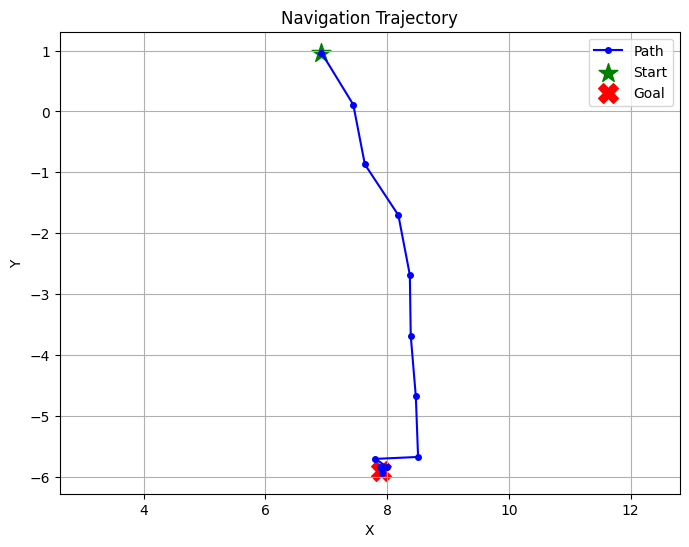

Epoch 4000, Loss: 33.5384
tensor([ 3.9219, -3.5293], device='cuda:0') tensor([6.5525, 0.8927], device='cuda:0')


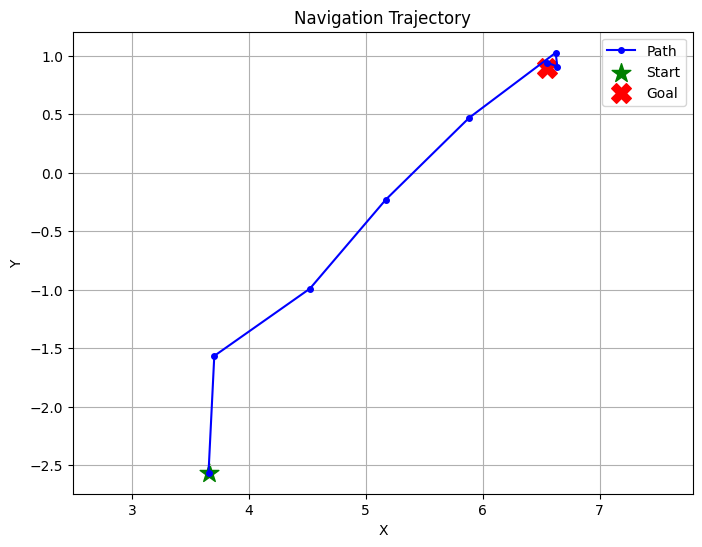

Epoch 4500, Loss: 343.9417
tensor([ 4.9101, -0.7830], device='cuda:0') tensor([-7.9000, -2.6558], device='cuda:0')


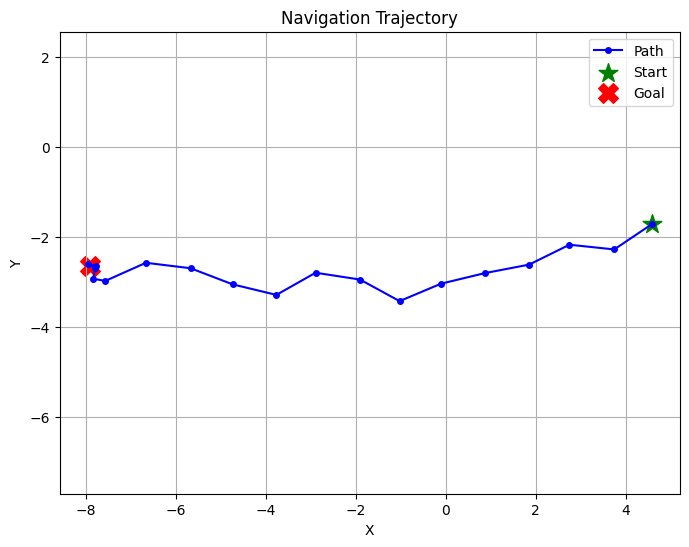

Epoch 5000, Loss: 773.2654
tensor([-7.8372,  1.2541], device='cuda:0') tensor([ 7.9000, -5.9000], device='cuda:0')


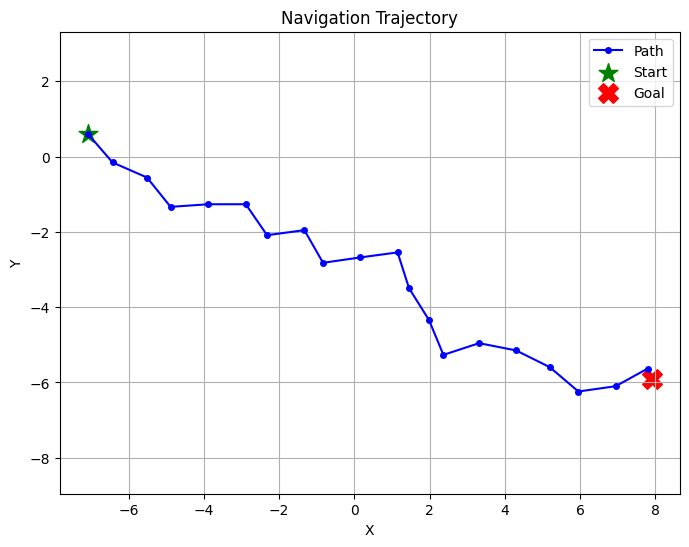

Epoch 5500, Loss: 44.0138
tensor([-2.9382,  2.8363], device='cuda:0') tensor([-7.9000,  5.9000], device='cuda:0')


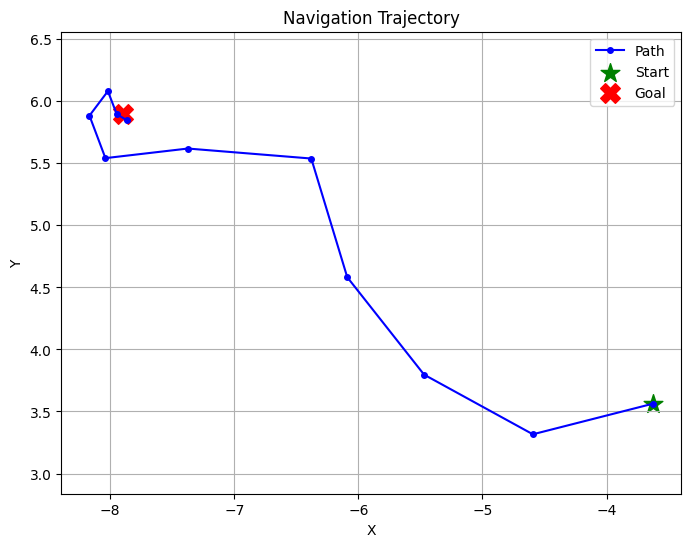

Epoch 6000, Loss: 29.9628
tensor([-3.4177,  2.8569], device='cuda:0') tensor([0.1511, 5.9000], device='cuda:0')


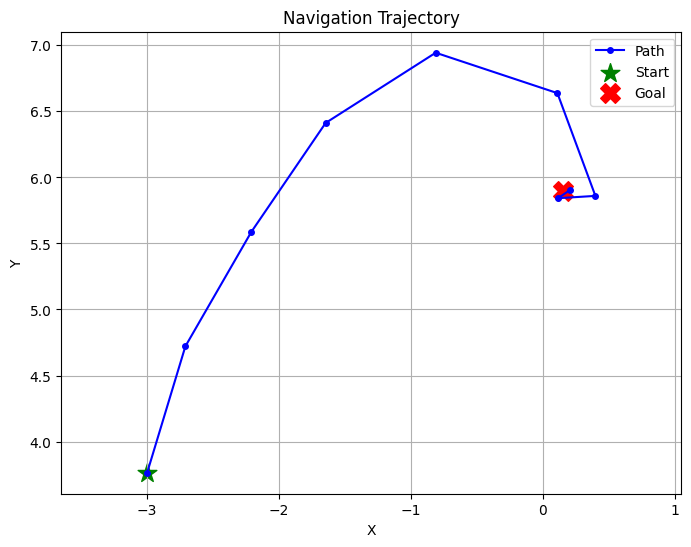

Epoch 6500, Loss: 35.2606
tensor([-6.8649,  3.6455], device='cuda:0') tensor([-7.9000, -1.3266], device='cuda:0')


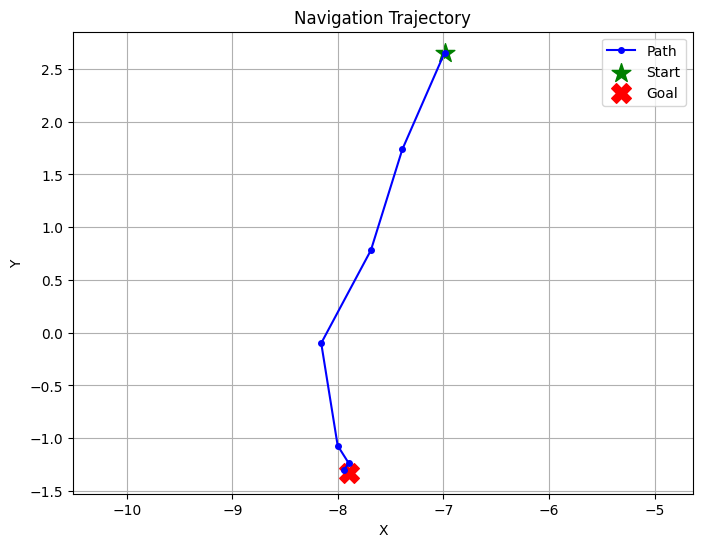

Epoch 7000, Loss: 84.9366
tensor([-5.0318, -3.4903], device='cuda:0') tensor([ 2.6380, -5.9000], device='cuda:0')


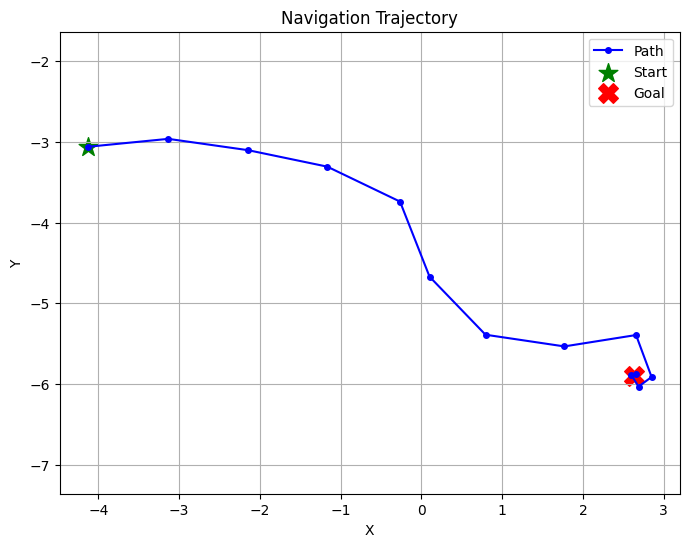

Epoch 7500, Loss: 146.3087
tensor([-5.5821,  5.9092], device='cuda:0') tensor([4.8354, 5.9000], device='cuda:0')


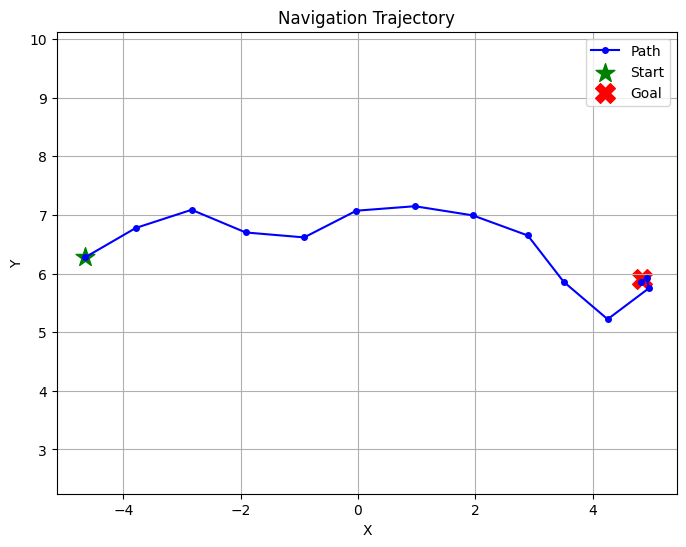

Epoch 8000, Loss: 190.3186
tensor([-3.7016,  0.0437], device='cuda:0') tensor([6.5154, 5.1067], device='cuda:0')


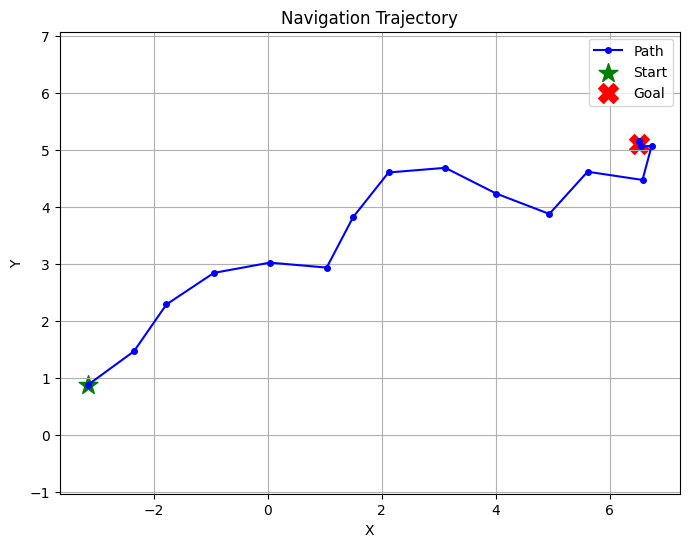

Epoch 8500, Loss: 47.1094
tensor([-3.6943,  2.3609], device='cuda:0') tensor([-7.9000,  5.9000], device='cuda:0')


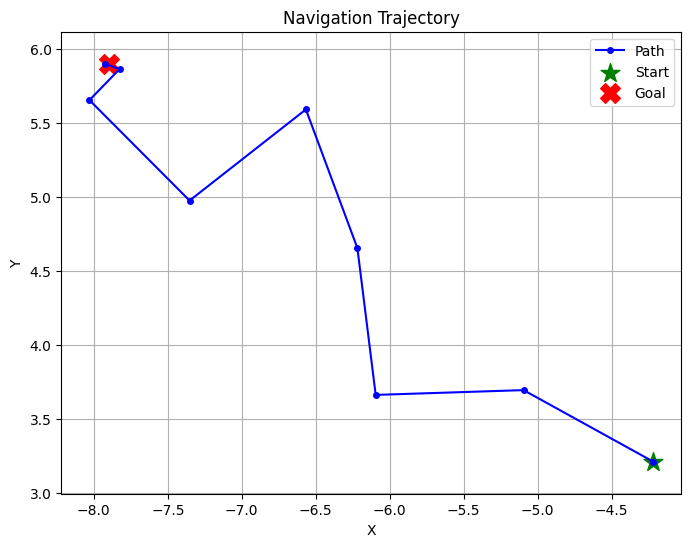

Epoch 9000, Loss: 92.1048
tensor([ 6.1108, -2.7157], device='cuda:0') tensor([7.9000, 5.9000], device='cuda:0')


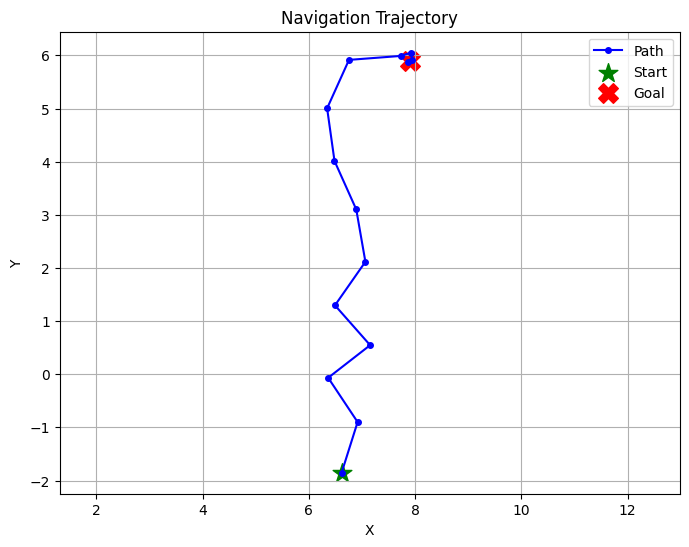

Epoch 9500, Loss: 151.6179
tensor([-2.9546, -4.7336], device='cuda:0') tensor([ 7.0800, -5.9000], device='cuda:0')


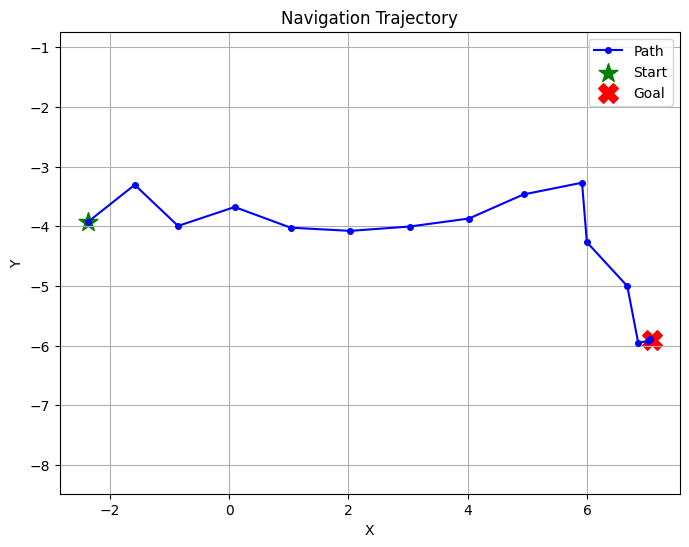

Epoch 10000, Loss: 110.4060
tensor([-1.2276, -0.6190], device='cuda:0') tensor([-7.9000,  5.9000], device='cuda:0')


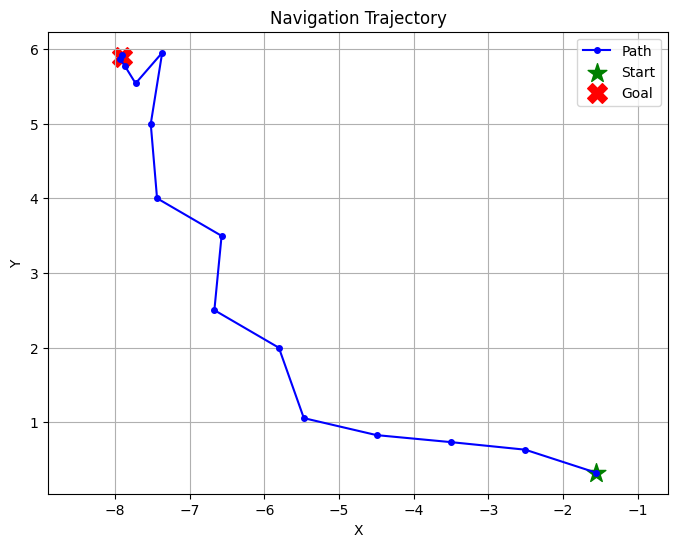

Epoch 10500, Loss: 75.0617
tensor([3.2857, 0.6890], device='cuda:0') tensor([ 6.9363, -5.9000], device='cuda:0')


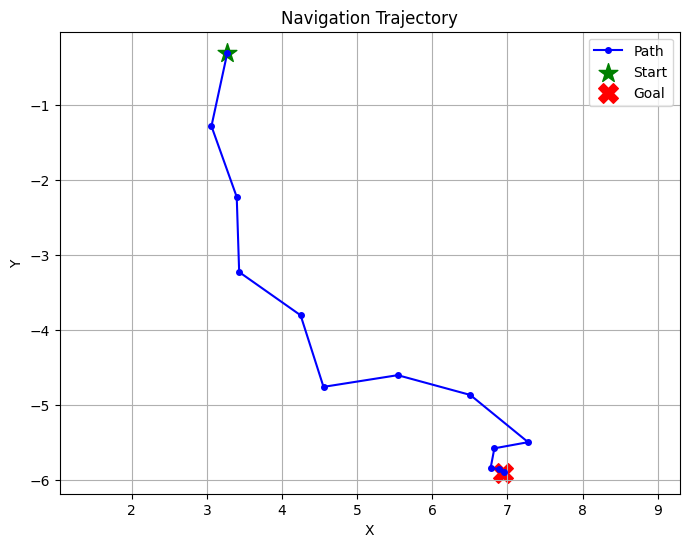

Epoch 11000, Loss: 228.5835
tensor([5.0218, 2.7283], device='cuda:0') tensor([-2.8529, -5.9000], device='cuda:0')


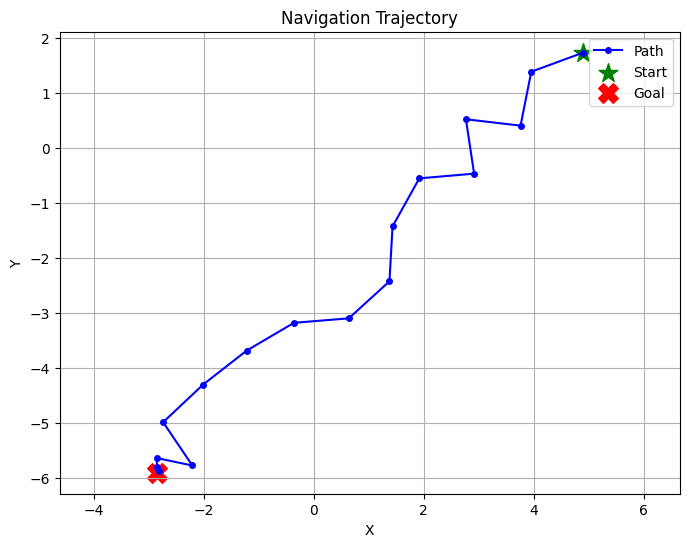

Epoch 11500, Loss: 60.4857
tensor([0.9986, 2.7680], device='cuda:0') tensor([7.9000, 2.9668], device='cuda:0')


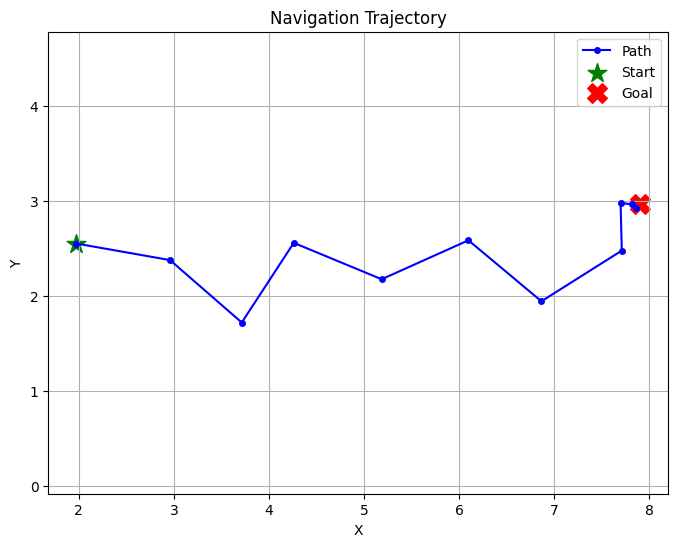

Epoch 12000, Loss: 110.3270
tensor([ 2.1299, -1.1458], device='cuda:0') tensor([7.9000, 5.9000], device='cuda:0')


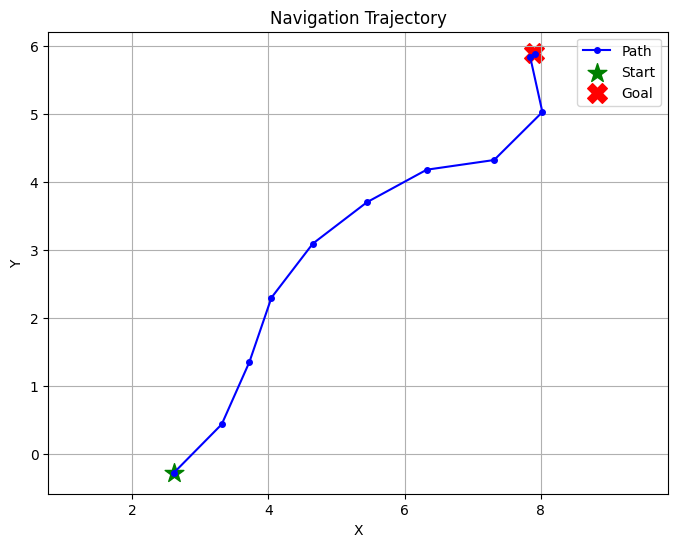

Epoch 12500, Loss: 90.7505
tensor([ 1.0886, -1.7670], device='cuda:0') tensor([5.4911, 5.9000], device='cuda:0')


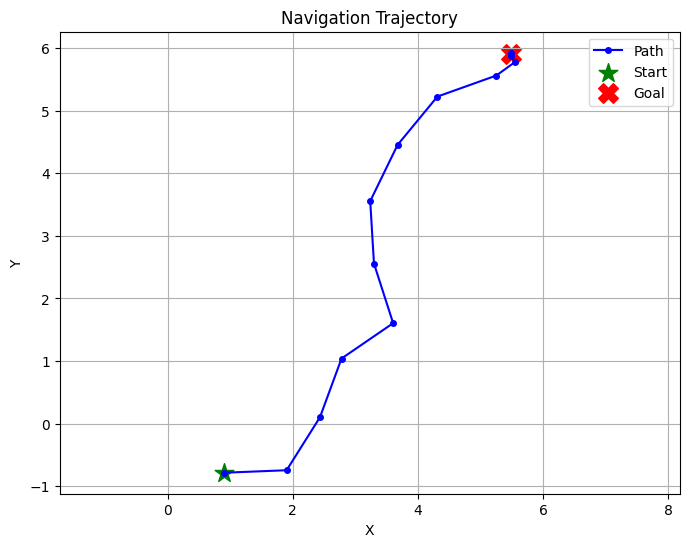

Epoch 13000, Loss: 27.6026
tensor([ 3.8011, -2.1555], device='cuda:0') tensor([ 7.9000, -3.7368], device='cuda:0')


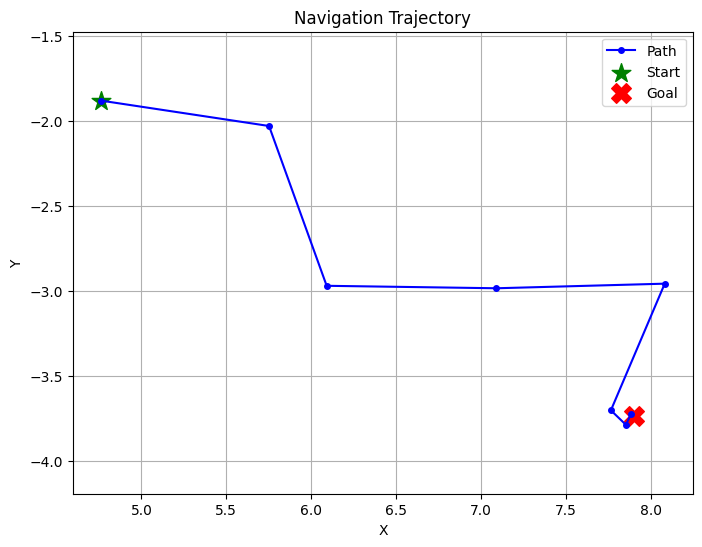

Epoch 13500, Loss: 9.6798
tensor([-3.3663,  5.5453], device='cuda:0') tensor([-1.3221,  5.9000], device='cuda:0')


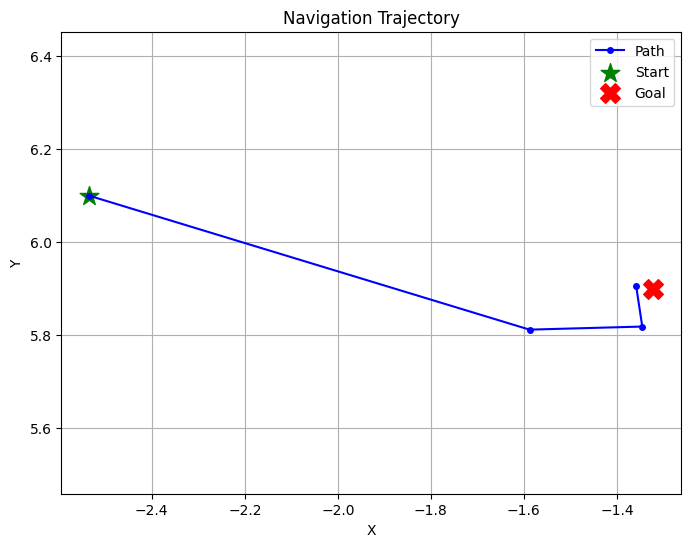

Epoch 14000, Loss: 23.5821
tensor([ 6.8838, -2.3269], device='cuda:0') tensor([7.9000, 1.2300], device='cuda:0')


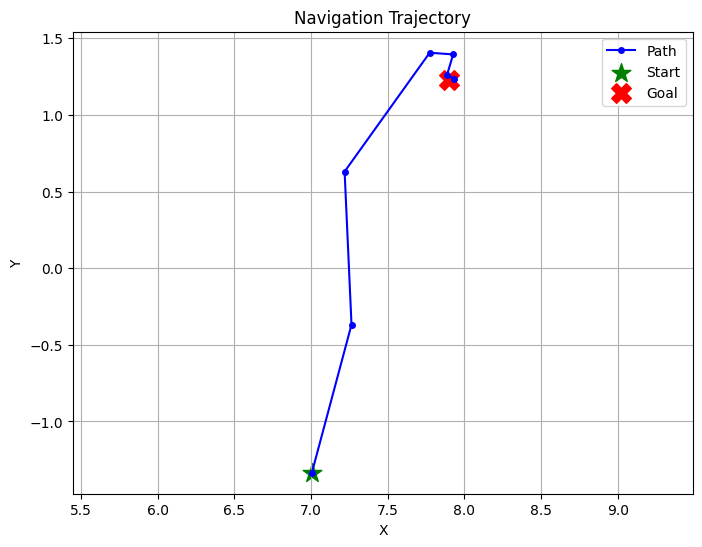

Epoch 14500, Loss: 79.0204
tensor([-0.1665,  2.9885], device='cuda:0') tensor([7.9000, 4.0638], device='cuda:0')


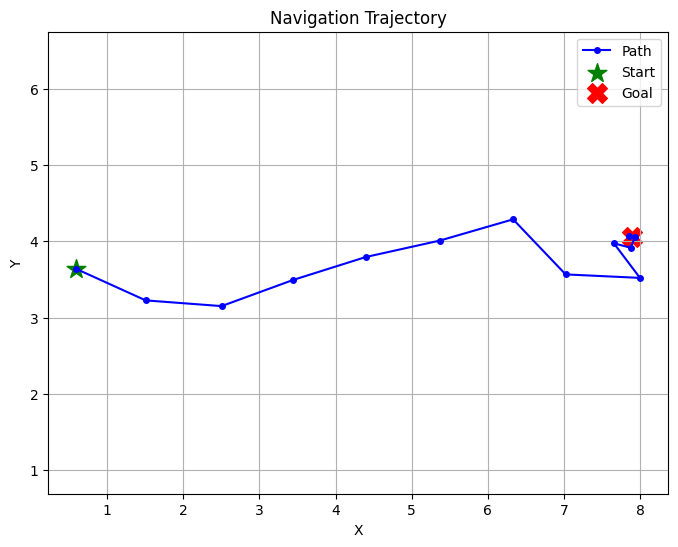

Epoch 15000, Loss: 26.9371
tensor([ 5.9293, -2.5141], device='cuda:0') tensor([7.9000, 0.4576], device='cuda:0')


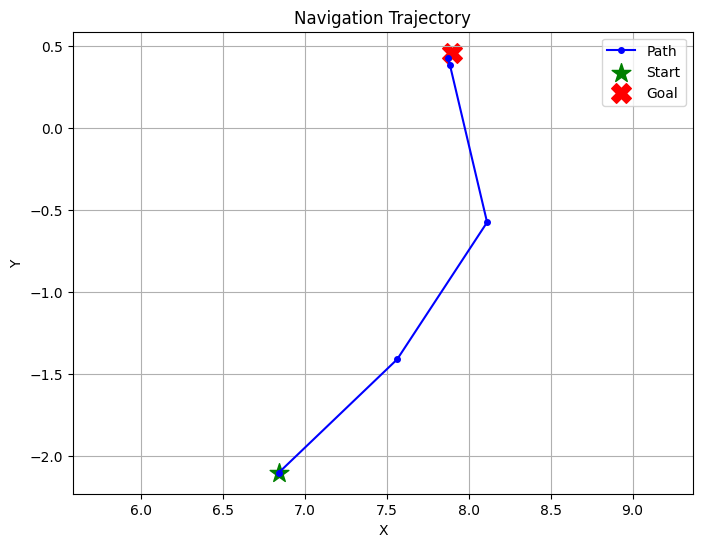

Epoch 15500, Loss: 112.9082
tensor([ 5.6772, -3.1528], device='cuda:0') tensor([7.9000, 5.9000], device='cuda:0')


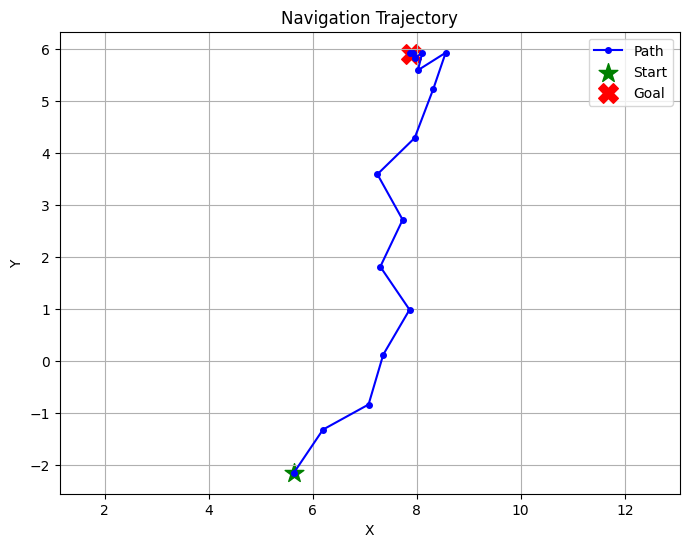

Epoch 16000, Loss: 69.0473
tensor([-0.9322,  0.2181], device='cuda:0') tensor([-6.4770, -3.6179], device='cuda:0')


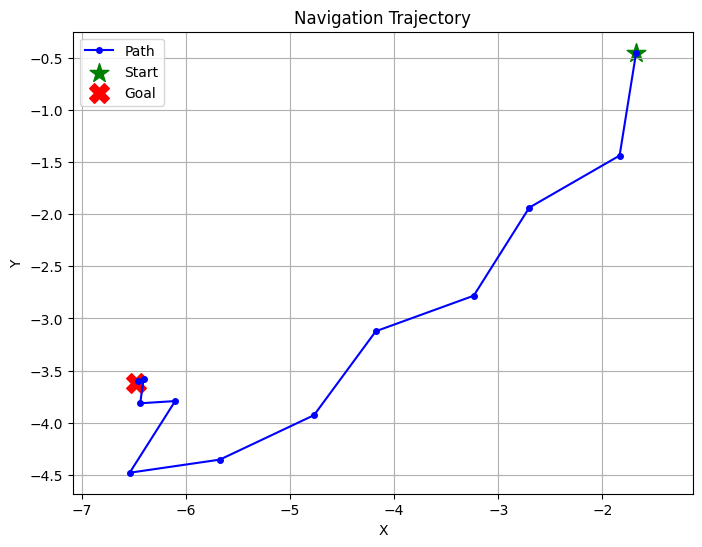

Epoch 16500, Loss: 165.3000
tensor([5.8188, 1.1148], device='cuda:0') tensor([-3.5654,  5.9000], device='cuda:0')


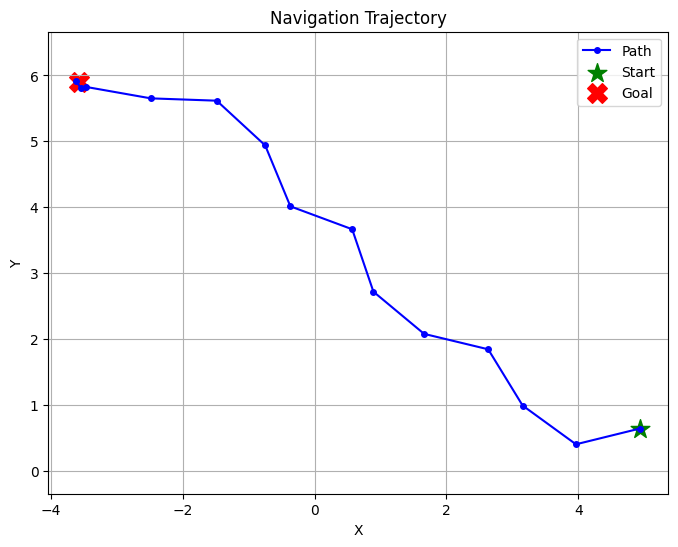

Epoch 17000, Loss: 115.7431
tensor([-4.6663, -3.8727], device='cuda:0') tensor([-7.9000,  4.9988], device='cuda:0')


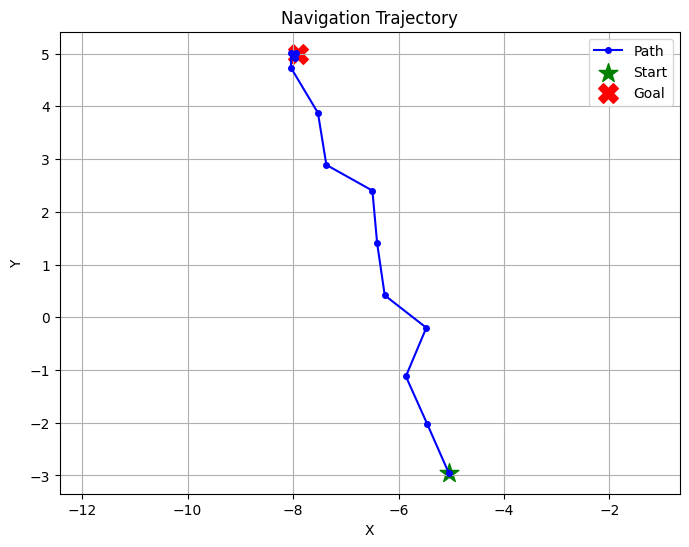

Epoch 17500, Loss: 153.7437
tensor([ 1.3745, -3.1471], device='cuda:0') tensor([-7.9000, -5.6194], device='cuda:0')


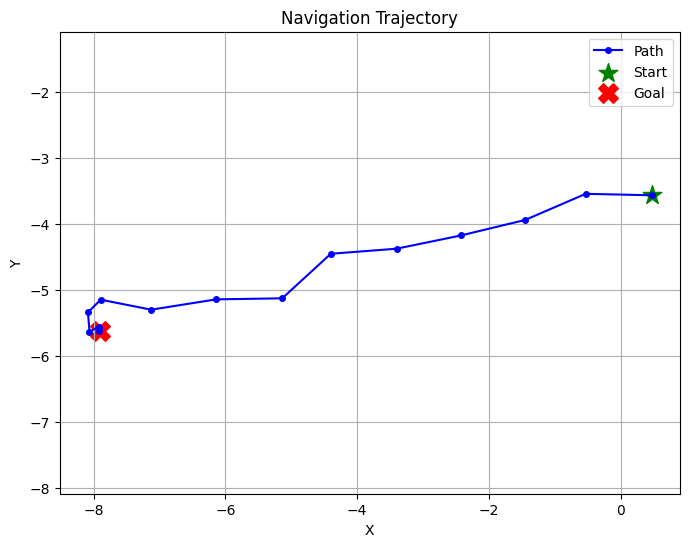

Epoch 18000, Loss: 36.2432
tensor([ 3.5846, -4.2429], device='cuda:0') tensor([ 7.9000, -1.0913], device='cuda:0')


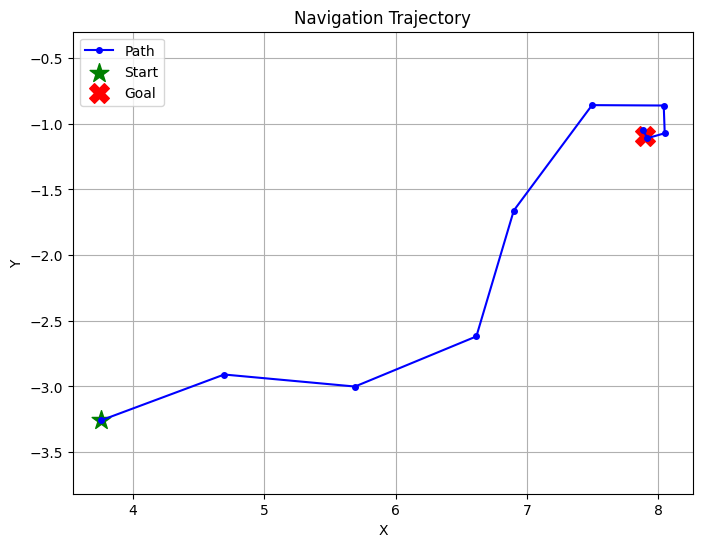

Epoch 18500, Loss: 58.0663
tensor([ 0.5568, -2.7250], device='cuda:0') tensor([-5.5312, -5.9000], device='cuda:0')


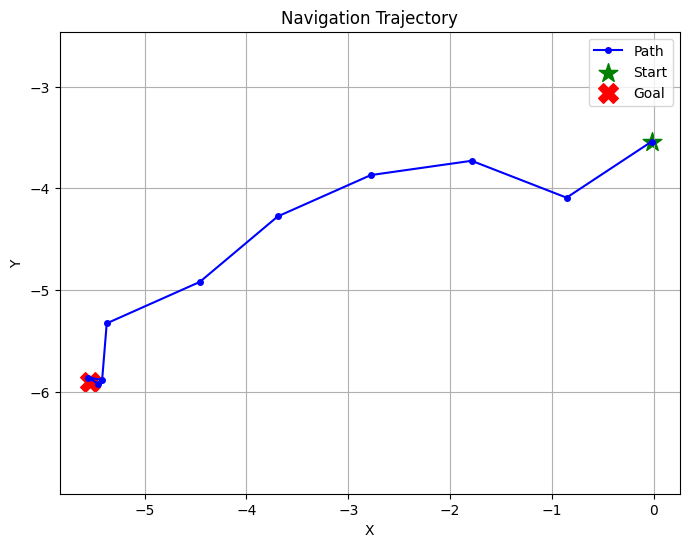

Epoch 19000, Loss: 38.9196
tensor([6.7237, 0.5833], device='cuda:0') tensor([ 1.2761, -1.6298], device='cuda:0')


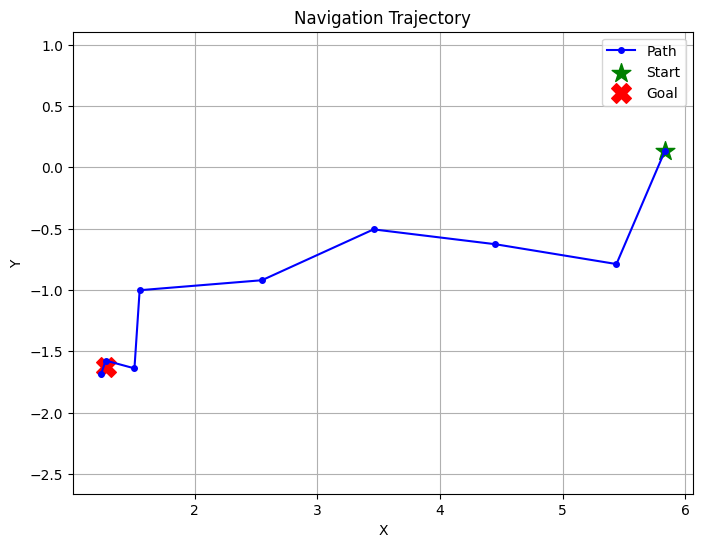

Epoch 19500, Loss: 37.2454
tensor([-6.6788, -1.1161], device='cuda:0') tensor([-7.9000,  3.3511], device='cuda:0')


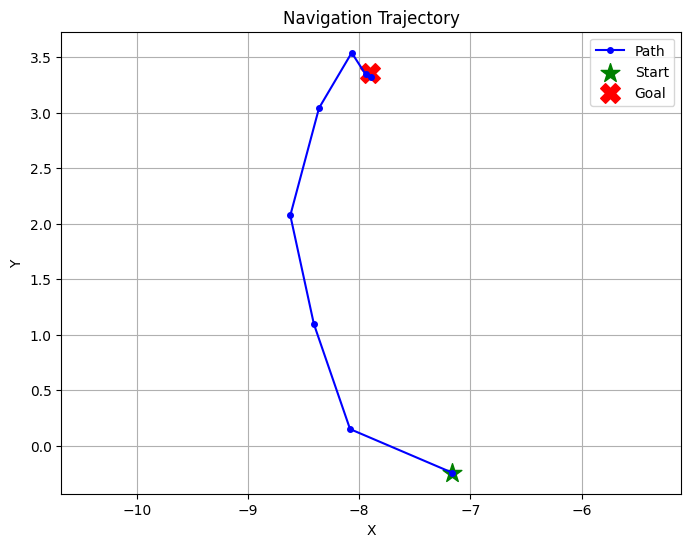

In [8]:
net = NavigationNet()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

for epoch in range(20000):
    # Generate batch using PhiFlow
    initial_pos, goal_pos = generate_batch(512, min_distance=0.1, max_distance=10.0)

    optimizer.zero_grad()
    output = physics_loss(net, initial_pos, goal_pos)
    loss = output[0] if isinstance(output, tuple) else output
    total_loss = loss.sum  # Sum the loss to get a scalar

    # Skip backward and step if loss is NaN/Inf
    if not torch.isfinite(total_loss):
        print(f"Epoch {epoch}: Loss is NaN/Inf, skipping update.")
        continue

    total_loss.backward()  # Backpropagate

    # Clip gradients to prevent explosion (adjust max_norm as needed)
    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

    # Check for NaNs in gradients
    has_nan = False
    for p in net.parameters():
        if p.grad is not None and not torch.all(torch.isfinite(p.grad)):
            has_nan = True
            break

    if has_nan:
        print(f"Epoch {epoch}: NaN detected in gradients, skipping step.")
        optimizer.zero_grad()  # Clear gradients to prevent contamination
    else:
        optimizer.step()  # Update parameters if no NaNs

    # Logging and plotting
    if epoch % 500 == 0:
        with torch.no_grad():
            initial_pos, goal_pos = generate_batch(1, 4)
            initial_torch = initial_pos.native("samples,vector").squeeze(0)
            goal_torch = goal_pos.native("samples,vector").squeeze(0)

            loss = physics_loss(net, initial_pos, goal_pos)
            print(f"Epoch {epoch}, Loss: {loss.native().item():.4f}")

            plot_trajectory(net, initial_torch, goal_torch)

In [9]:
torch.save(net, 'mod_act_nav.pth')

C:\Users\rahat\AppData\Local\Temp\ipykernel_21188\3627828045.py:60: DeprecationWarning: phiml.math.length is deprecated in favor of phiml.math.norm
  path_length += math.vec_length(movement)
C:\Users\rahat\AppData\Local\Temp\ipykernel_21188\3627828045.py:67: DeprecationWarning: phiml.math.length is deprecated in favor of phiml.math.norm
  position_loss = temporal_weight * math.vec_length(delta_pos)
C:\Users\rahat\AppData\Local\Temp\ipykernel_21188\3627828045.py:72: DeprecationWarning: phiml.math.length is deprecated in favor of phiml.math.norm
  current_pos = math.where(math.vec_length(delta_pos) > 0.1, new_pos, current_pos)
C:\Users\rahat\AppData\Local\Temp\ipykernel_21188\3627828045.py:43: DeprecationWarning: phiml.math.vec_squared is deprecated in favor of phiml.math.squared_norm
  control_change = math.vec_squared(controls - prev_controls)
C:\Users\rahat\AppData\Local\Temp\ipykernel_21188\3627828045.py:74: DeprecationWarning: phiml.math.length is deprecated in favor of phiml.math.n

tensor([ 4.5000, -3.2000]) tensor([ 2.1000, -6.1000])


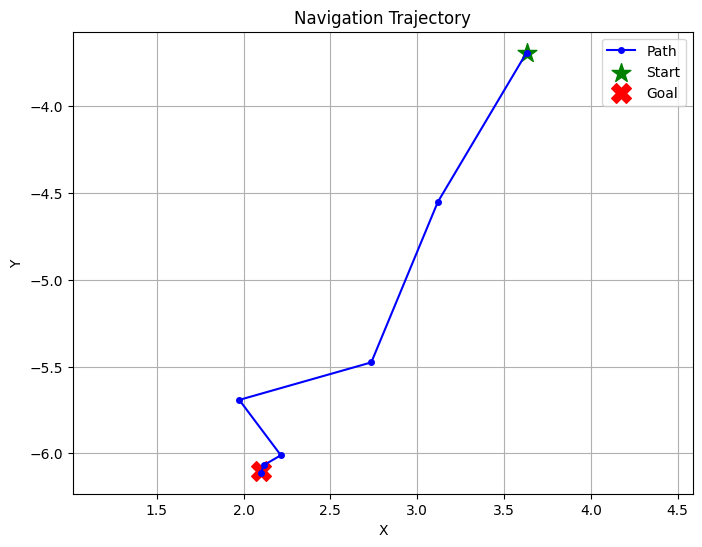

In [13]:
net = torch.load(r'F:\Aerosim-Simulation-Zone\Try\mod_act_nav.pth', weights_only=False)
with torch.no_grad():
    initial_torch = torch.tensor([4.5, -3.2], dtype=torch.float32)
    goal_torch = torch.tensor([2.1, -6.1], dtype=torch.float32)

    loss = physics_loss(net, initial_pos, goal_pos)
    # print(f"Epoch {epoch}, Loss: {loss.native().item():.4f}")

    plot_trajectory(net, initial_torch, goal_torch, 60)

In [ ]:
net = torch.load('nav_model.pth')

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def adjust_direction(lidar_points, proposed_displacement, n):
    """
    Adjust the proposed (linear, angular) displacement to avoid obstacles.

    Args:
        lidar_points: (batch, 360) array of obstacle distances.
                      A reading of 0 means no obstacle.
        proposed_displacement: (batch, 2) array [linear, angular] displacement.
        n: safety margin in degrees (±n around the proposed angle).

    Returns:
        Adjusted displacement as a (batch, 2) array.
        For a batch element with no safe candidate, the linear velocity is set to 0.
    """
    batch_size = lidar_points.shape[0]
    # Ensure proposed angles are in [0,360)
    L = proposed_displacement[:, 0]
    theta = proposed_displacement[:, 1] % 360  
    abs_L = np.abs(L)
    if L < 0:
        # theta = (theta + 180) % 360
        theta = (theta - 180) % 360

    # --- Step 1: Check the safety of the proposed angle ---
    # Use the rounded (integer) angle for indexing.
    theta_round = np.round(theta).astype(int) % 360
    window_offsets = np.arange(-n, n + 1)
    indices = (theta_round[:, None] + window_offsets) % 360  # shape: (batch, 2n+1)
    # Extract the lidar readings from the safety window.
    readings = np.take_along_axis(lidar_points, indices, axis=1)
    # A reading is dangerous if it is > 0 and is less than or equal to the displacement.
    danger = (readings > 0) & (readings <= 1.5*abs_L[:, None])
    is_proposed_safe = ~danger.any(axis=1)

    # print("is_prozposed_safe: ", is_proposed_safe, theta_round)

    # Prepare outputs.
    new_L = L.copy()
    new_theta = theta.copy()

    # --- Step 2: For unsafe cases, search for a safe alternative ---
    unsafe = np.where(~is_proposed_safe)[0]
    if unsafe.size > 0:
        # Precompute candidate angles and their safety windows.
        candidate_angles = np.arange(360)
        candidate_windows = (candidate_angles[:, None] + window_offsets) % 360  # shape: (360, 2n+1)
        
        for i in unsafe:
            lidar_row = lidar_points[i]  # (360,)
            # For every candidate angle, get its window's readings.
            candidate_readings = lidar_row[candidate_windows]  # shape: (360, 2n+1)
            # Candidate is safe if none of the readings in its window are dangerous.
            candidate_safe = ~((candidate_readings > 0) & (candidate_readings <= 1.5*abs_L[i])).any(axis=1)
            
            if not candidate_safe.any():
                # No safe candidate found: cancel motion.
                new_L[i] = new_L[i]/2
                print("no path found")
            else:
                # Compute circular difference between candidate angles and proposed angle.
                diff = np.abs(candidate_angles - theta[i])
                diff = np.minimum(diff, 360 - diff)
                # Penalize unsafe candidates.
                diff[~candidate_safe] = 360  
                best_angle = candidate_angles[np.argmin(diff)]
                new_theta[i] = best_angle %360

    print("new theta", new_theta, "prev theta", theta)
    if new_L < 0:
        new_theta = (new_theta - 180) % 360
    return np.stack([new_L, new_theta], axis=1)

In [ ]:

# ===== Create Sample Data =====
# We'll create 4 samples (batch size = 4) with 360 lidar readings each.
# A reading of 0 means no obstacle; a positive value indicates an obstacle at that distance.
batch_size = 4
lidar_points = np.zeros((batch_size, 360), dtype=float)
proposed_displacement = np.zeros((batch_size, 2), dtype=float)
n = 2  # safety margin (±5 degrees)

# Sample 0: Proposed direction is safe.
#   L = 5, theta = 90°; no obstacles.
proposed_displacement[0] = [1, 0]
# lidar_points[0] remains all zeros.

# Sample 1: Proposed direction is unsafe, but a safe alternative exists.
#   L = 5, theta = 10°.
proposed_displacement[1] = [5, 10]
# Place an obstacle within the safety window of the proposed angle.
# The safety window for theta=10 (rounded) with n=5 is: [5,6,...,15].
lidar_points[1, 10] = 5  # Obstacle at angle 10 with distance 3 (<5).
lidar_points[1, 9] = 3
lidar_points[1, 8] = 2
lidar_points[1, 6] = 4
lidar_points[1, 11] = 4
lidar_points[1, 12] = 4
lidar_points[1, 13] = 4
lidar_points[1, 14] = 4


# Sample 2: No safe alternative exists.
#   L = 5, theta = 200°.
proposed_displacement[2] = [5, 200]
# Fill the entire lidar row with obstacles (distance=3).
lidar_points[2, :] = 3

# lidar_points[2, 20:25] = 0

# Sample 3: Proposed direction is unsafe.
#   L = 5, theta = 350°.
proposed_displacement[3] = [5, 350]
# Safety window for theta=350 (rounded) with n=5 is [345, ..., 355].
lidar_points[3, 333:360] = 3  # Obstacle at 350 with distance 3.

# Adjust directions.
adjusted = adjust_direction(lidar_points, proposed_displacement, n)

# ===== Plotting Code =====
# We will create a polar plot for each sample showing:
#   - The lidar readings as points.
#   - The proposed displacement vector.
#   - The adjusted (safe) displacement vector.
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 10))
axes = axes.flatten()

for i in range(batch_size):
    ax = axes[i]
    # Plot the lidar readings.
    # Lidar indices represent angles in degrees. We convert them to radians.
    angles_deg = np.arange(360)
    angles_rad = np.deg2rad(angles_deg)
    # Use the lidar distance as radius.
    # We plot only nonzero obstacles as red dots.
    safe_readings = lidar_points[i] > 0
    ax.scatter(angles_rad[safe_readings], lidar_points[i][safe_readings], 
               c='red', s=20, label='Obstacle')
    
    # Plot the proposed displacement vector.
    # The vector originates at 0 and extends out to length L in the proposed angle.
    prop_angle_rad = np.deg2rad(proposed_displacement[i, 1] % 360)
    ax.arrow(prop_angle_rad, 0, 0, proposed_displacement[i, 0],
             color='blue', width=0.1, label='Proposed', alpha=0.8,
             length_includes_head=True)
    
    # Plot the adjusted displacement vector.
    adj_angle_rad = np.deg2rad(adjusted[i, 1] % 360)
    ax.arrow(adj_angle_rad, 0, 0, adjusted[i, 0],
             color='green', width=0.1, label='Adjusted', alpha=0.8,
             length_includes_head=True)
    
    # Set title for this subplot.
    ax.set_title(f"Sample {i}\nProposed: {proposed_displacement[i]}  Adjusted: {adjusted[i]}")
    ax.set_rmax(6)
    ax.grid(True)
    # Only show legend in one subplot.
    if i == 0:
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [86]:
from PIL import Image

In [87]:
image_path = "New_WR_World.png"
img = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale
binary_img = (img > 128).astype(np.uint8)  # Threshold to create a binary map
binary_img = cv2.resize(binary_img, (0,0), fx=0.25, fy=0.25)

In [88]:
pts, dists = get_lidar_points(binary_img, [4,4], [(-10, 10),(-8, 8)], num_rays=360, max_range=5.0)

In [ ]:
pts+=[np.array([4,4])]
plt.scatter(pts[:, 0], pts[:, 1])
plt.scatter(4, 4, c='red')
plt.xlim(-10, 10)
plt.ylim(-7, 7)

In [90]:
def adjust_actions( lidar_points, proposed_action, world_theta, n, debug=False):
    """
    Adjust the proposed (L, θ) action to avoid collisions and move into the closest free space.
    This function takes the LiDAR scan data (batch, 360) and a proposed action (batch, 2) provided
    in normalized units (both values between -1 and 1). The linear component (L) is interpreted as
    L * max_step_size, and the angular component (θ) is computed as follows:
       1. Convert the robot's current world orientation (world_theta, given in degrees) to radians.
       2. Compute an angular offset by scaling the normalized proposed angular value by π (i.e. ±π radians).
       3. Compute the desired heading as:
              desired_heading (radians) = world_theta (in radians) + (proposed_action[θ] * π)
       4. Convert the desired heading to degrees (in the 0-359 range) for performing LiDAR safety checks.
    If a collision is predicted (using a safety window of ±n deg), the function searches for an alternative,
    and may reduce the linear component if necessary. Finally, the new angular value is converted back
    to a normalized value in [-1,1] (by dividing the found angular displacement (in radians) by π).
    Args:
        lidar_points (np.ndarray): Array of shape (batch, 360) with LiDAR distances.
        proposed_action (np.ndarray): Array of shape (batch, 2) with normalized action values in [-1,1]
                                      for [linear, angular] displacement.
        world_theta (float): The current world orientation of the robot in degrees.
        n (int): Safety margin in degrees for collision checking (±n).
        debug (bool): If True, prints debug statements.
    Returns:
        np.ndarray: Adjusted action of shape (batch, 2) with normalized values in [-1,1].
    """
    if debug:
        print(f"DEBUG: Initial proposed_action: {proposed_action}")
    # If the proposed_action is 1-dimensional, expand its dimensions.
   
    was_single_action = False
    if proposed_action.ndim == 1:
        proposed_action = np.expand_dims(proposed_action, axis=0)
        was_single_action = True
    proposed_action[:, 0] = np.abs([proposed_action[:, 0]])
    # Environment constants.
    max_step_size = 1.0  # Actual maximum displacement (units)
    max_theta = np.pi    # Maximum angular change in radians (i.e. normalized ±1 -> ±π)
    batch_size = proposed_action.shape[0]
    new_action = np.zeros((batch_size, 2))  # initialize the output array
    # Convert the normalized linear action to actual displacement.
    actual_L = np.abs(proposed_action[:, 0]) * max_step_size
    if debug:
        print(f"DEBUG: Computed actual_L: {actual_L}")
    # Convert world_theta (in degrees) to radians.
    world_theta_rad = np.deg2rad(world_theta)
    # Compute the angular offset (in radians) from the normalized proposed action.
    action_theta_offset_rad = proposed_action[:, 1] * max_theta

    if proposed_action[0, 1] < 0:
        action_theta_offset_rad = action_theta_offset_rad - np.pi
    # Desired new heading in radians.
    desired_heading_rad = world_theta_rad + action_theta_offset_rad
    # Convert desired heading to degrees within 0-359.
    actual_theta_deg = np.rad2deg(desired_heading_rad) % 360
    if debug:
        print(f"DEBUG: Computed desired_heading (deg): {actual_theta_deg}")
    # Expand lidar_points to include batch dimension if needed.
    if lidar_points.ndim == 1:
        lidar_points = lidar_points[np.newaxis, :]
    if debug:
        print(f"DEBUG: lidar_points shape after potential expansion: {lidar_points.shape}")
    # Loop over each sample.
    for i in range(batch_size):
        if debug:
            print(f"DEBUG: Processing sample {i}")
        # Define a narrow safety window ±n degrees.
        window_offsets = np.arange(-n, n + 1)
        if debug:
            print(f"DEBUG: window_offsets: {window_offsets}")
        # Round the intended heading (in degrees) to an integer.
        proposal_angle = np.round(actual_theta_deg[i]).astype(int)
        if debug:
            print(f"DEBUG: Sample {i} proposal_angle: {proposal_angle}")
        indices = (proposal_angle + window_offsets) % 360
        if debug:
            print(f"DEBUG: Sample {i} safety window indices: {indices}")
        readings = lidar_points[i, indices]
        if debug:
            print(f"DEBUG: Sample {i} LiDAR readings in safety window: {readings}")
        # If any reading in the window is <= 1.5 * max_step_size, the action is unsafe.
        if (readings <= max_step_size * 1.5).any():
            if debug:
                print(f"DEBUG: Sample {i}: Proposed action is unsafe.")
            candidate_range = np.arange(-n, n+1)
            candidate_angles = (proposal_angle + candidate_range) % 360
            if debug:
                print(f"DEBUG: Sample {i}: candidate_range: {candidate_range}")
                print(f"DEBUG: Sample {i}: candidate_angles: {candidate_angles}")
            best_candidate = None
            best_diff = 360  # Initialize with maximum possible angular difference.
            candidate_safe_distance = 0
            # Evaluate candidate angles within the safety window.
            for cand in candidate_angles:
                cand_indices = (cand + window_offsets) % 360
                cand_readings = lidar_points[i, cand_indices]
                cand_safe_dist = np.min(cand_readings)
                diff_angle = min(abs(cand - actual_theta_deg[i]), 360 - abs(cand - actual_theta_deg[i]))
                if debug:
                    print(f"DEBUG: Sample {i}: Evaluating candidate angle {cand}:")
                    print(f"       cand_indices: {cand_indices}")
                    print(f"       cand_readings: {cand_readings}")
                    print(f"       cand_safe_dist: {cand_safe_dist}, diff_angle: {diff_angle}")
                # Choose candidate if it has enough free space and is closer in angle to the original.
                if (cand_safe_dist > 0 and cand_safe_dist >= (max_step_size - 1e-2)) and diff_angle < best_diff:
                    best_diff = diff_angle
                    best_candidate = cand
                    candidate_safe_distance = cand_safe_dist
                    if debug:
                        print(f"DEBUG: Sample {i}: New best candidate found: {cand} with diff {best_diff} and safe distance {cand_safe_dist}")
            # If no candidate was found, reduce the linear displacement.
            if best_candidate is None:
                new_actual_L = actual_L[i] * 0.5
                new_actual_theta_deg = actual_theta_deg[i]
                if debug:
                    print(f"DEBUG: Sample {i}: No free candidate found; halving L to {new_actual_L}.")
            else:
                new_actual_theta_deg = best_candidate
                margin = 0.9  # Use a safety margin.
                new_actual_L = min(actual_L[i], candidate_safe_distance * margin)
                if debug:
                    print(f"DEBUG: Sample {i}: Candidate angle {best_candidate}° selected with safe distance {candidate_safe_distance}.")
                    print(f"DEBUG: Sample {i}: New linear displacement set to {new_actual_L}.")
            # Normalize the adjusted linear and angular actions.
            new_action[i, 0] = np.clip(new_actual_L / max_step_size, -1, 1)
            new_theta_rad = np.deg2rad(new_actual_theta_deg)
            new_action[i, 1] = np.clip(new_theta_rad / max_theta, -1, 1)
            if debug:
                print(f"DEBUG: Sample {i}: Updated action: linear = {new_action[i, 0]}, angular (normalized) = {new_action[i, 1]}")
        elif (readings <= max_step_size * 3).any():
            new_action[i, 0] = actual_L[i] / 2
            if debug:
                print(f"DEBUG: Sample {i}: Proposed action is safe but L is halved to {new_action[i, 0]}")
        else:
            # If no adjustments are needed, pass the proposed normalized action.
            new_action[i, 0] = proposed_action[i, 0]
            new_action[i, 1] = proposed_action[i, 1]
            if debug:
                print(f"DEBUG: Sample {i}: Proposed action is safe, no adjustments made.")
    if was_single_action:
        if debug:
            print(f"DEBUG: Returning single action: {new_action[0]}")
        return new_action[0]
    if debug:
        print(f"DEBUG: Returning batch of actions: {new_action}")
        print("DEBUG: Exiting adjust_actions")
    new_action[:, 1] = np.abs(new_action[:, 1])
    return new_action

In [91]:
import matplotlib.pyplot as plt
import torch

def plot_trajectory(net, initial_pos, goal_pos, max_steps=12):
    """Simulate and plot a single trajectory using PyTorch tensors"""
    with torch.no_grad():
        current_pos = initial_pos.clone()
        goal_pos = goal_pos.clone()
        # net = net.to('cuda' if torch.cuda.is_available() else 'cpu')
        net = net.to('cpu')

        print(current_pos, goal_pos)
        
        theta = torch.zeros_like(current_pos[0])
        positions = []
        lidar_pts = []
        
        for stp in range(max_steps):
            delta_pos = goal_pos - current_pos
            relative_theta = torch.atan2(delta_pos[1], delta_pos[0]) - theta

            relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi

            pts, dists = get_lidar_points(binary_img, current_pos.numpy(), [(-10, 10),(-8, 8)], num_rays=360, max_range=5.0)
            # print(dists)
            lidar_pts.append(pts+current_pos.numpy())
            
            net_input = torch.stack([
                current_pos[0]/8, current_pos[1]/6,
                goal_pos[0]/8, goal_pos[1]/6,
                theta/math.PI, relative_theta/math.PI
            ], dim=-1).unsqueeze(0)
            
            controls = net(net_input)[0]
            L = controls[0]
            delta_theta = controls[1]*math.PI

            # print(L, delta_theta, theta, torch.clip(delta_theta, -math.PI/9, math.PI/9))
            # controls2 = adjust_actions(dists, controls.numpy(),  np.rad2deg(theta.numpy()), 3,  True)

            # L = controls2[0]
            # delta_theta = controls2[1]*math.PI

            # theta = theta + delta_theta
            # theta = (theta + np.pi) % (2 * np.pi) - np.pi 

            # print(.shape, .shape)
            

            l = adjust_direction(dists[np.newaxis, :], np.array([[L,np.rad2deg(theta)]]), 3)
           


            # print(l)
            
            ad_theta = torch.tensor(np.deg2rad(l[0, 1]))
            # print(theta, ad_theta)

            ad_theta = (ad_theta + np.pi) % (2 * np.pi) - np.pi 

            print(f'adjusted: {np.rad2deg(ad_theta.numpy())- np.rad2deg(theta)}')


            # print("step", stp, " ", np.rad2deg(theta), net_input)
        
            
            # theta += delta_theta
            # movement = torch.stack([
            #     L * torch.cos(theta),
            #     L * torch.sin(theta)
            # ])

            movement = torch.stack([
                L * torch.cos(ad_theta),
                L * torch.sin(ad_theta)
            ])


            
            current_pos += movement
            # Append a copy of the numpy array to avoid reference issues
            positions.append(current_pos.cpu().numpy().copy())  # Fixed line

            # break
            
            if torch.norm(delta_pos) < 0.1:
                break
        
        positions = np.array(positions)
        # Rest of the plotting code remains the same
        plt.figure(figsize=(8, 6))
        plt.imshow(binary_img, extent=[-10, 10, -8, 8], aspect='auto')
        plt.plot(positions[:, 0], positions[:, 1], 'b-o', markersize=4, label='Path')
        # for pt in lidar_pts:
        #     plt.scatter(pt[:, 0], pt[:, 1])

        # circle_points = np.array([[3 + 1 * np.cos(theta), -2 + 1 * np.sin(theta)] 
        #                   for theta in np.linspace(0, 2*np.pi, 100)])
        # plt.plot(circle_points[:, 0], circle_points[:, 1], 'g-', linewidth=2)

        plt.scatter(positions[0, 0], positions[0, 1], c='green', s=200, marker='*', label='Start')
        plt.scatter(goal_pos[0].item(), goal_pos[1].item(), c='red', s=200, marker='X', label='Goal')
        plt.title("Navigation Trajectory")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid(True)
        plt.xlim(-10, 10)
        plt.ylim(-8, 8)
        plt.axis('equal')
        plt.legend()
        plt.show()


In [ ]:
with torch.no_grad():
    initial_torch = torch.tensor([5.2, -2], dtype=torch.float32)
    goal_torch = torch.tensor([-1, -2], dtype=torch.float32)

    loss = physics_loss(net, initial_pos, goal_pos)
    # print(f"Epoch {epoch}, Loss: {loss.native().item():.4f}")

    plot_trajectory(net, initial_torch, goal_torch, 60)

In [ ]:
np.array([[1,3]]).shape

In [ ]:
a = np.rad2deg(-0.39*np.pi)
print(a)
b = np.rad2deg(1.53*np.pi)
print(b)


In [ ]:
a = 0.33
b = a * 360
c = np.rad2deg(a*np.pi)
print(b)
print(c)